# Sensitivity Analysis of Population Estimation Strategies

Authors: Todd Nief and Launa Greer

This notebook compares population estimates derived from areal and point interpolation with official populations published by the U.S. Census Bureau to better understand tradeoffs in accuracy. For our case studies, we interpolated populations in census block groups and census tracts to populations in distressed zip code tabulation areas (ZCTAs) and municipalities using each of the two techniques. NOTE: Running this notebook for the first time may take up to 20-30 minutes, after which the newly-created datasets are cached to the local file system. In addition, interactive maps are automatically generated and opened in a new browser window.

## 1. Setup

In [1]:
# Magic options
%load_ext autoreload
%autoreload 2

In [2]:
# Third-party imports
import pandas as pd
from statsmodels.stats.power import TTestPower

# Application imports
from utils.constants import (
    CLEAN_ANALYSIS_DIR,
    CLEAN_GEOPARQUET_DIR,
    DISTRESSED_ZCTAS_FNAME,
    MUNICIPALITIES_FNAME,
)
from utils.analysis import (
    get_interpolations,
    map_block_group_discrepancies,
    map_tract_discrepancies,
    plot_population_distribution,
    plot_population_error_distribution,
    run_paired_t_test,
    OriginGeo,
    TargetGeo
)
from utils.load import (
    load_block_groups,
    load_block_group_pop_centroids,
    load_tracts,
    load_tract_pop_centroids
)

In [3]:
# Cell formatting
pd.options.display.float_format = '{:.5f}'.format

## 2. Load Datasets

Census block group and tract boundaries from the 2020 U.S. Census were originally sourced from Census Bureau TIGER/Line Shapefiles, while their corresponding population counts were downloaded from **[data.census.gov](https://data.census.gov/)** as CSV files. Here, we read the datasets from the local file system and merge them together along geography type to create boundaries annotated with population data. We also read in population-weighted centroids for block groups and tracts that were originally hosted by the Census Bureau **[here](https://www.census.gov/geographies/reference-files/time-series/geo/centers-population.html)**.  Finally, we filter all records to the 50 U.S. States and District of Columbia only, excluding the Island Areas of American Samoa, the Commonwealth of the Northern Mariana Islands, Guam, Puerto Rico, and the U.S. Virgin Islands.

### 2A. Census Block Groups

In [4]:
# Load block group boundaries with population estimates
blk_grps_gdf = load_block_groups()
blk_grps_gdf.head(2)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,POPULATION
0,01,033,020200,1,010330202001,Block Group 1,G5030,S,994584,105643,+34.7664259,-087.6960323,"POLYGON ((-87.70081 34.76189, -87.70081 34.762...",1171.00000
1,01,019,956000,1,010199560001,Block Group 1,G5030,S,8601894,0,+34.1513552,-085.6520464,"POLYGON ((-85.67917 34.15255, -85.67904 34.152...",756.00000


In [5]:
# Load population-weighted block group centroids
blk_grp_centroids_gdf = load_block_group_pop_centroids()
blk_grp_centroids_gdf.head(2)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,POPULATION,LATITUDE,LONGITUDE,geometry
0,1,1,20100,1,575,32.46447,-86.48630,POINT (-86.48630 32.46447)
1,1,1,20100,2,1200,32.48274,-86.48674,POINT (-86.48674 32.48274)


In [6]:
# Subset data to 50 U.S. States only
blk_grps_gdf = blk_grps_gdf.query("STATEFP < '60'")
blk_grp_centroids_gdf = blk_grp_centroids_gdf.query("STATEFP < 60")

### 2B. Census Tracts

In [7]:
# Load tracts with population estimates
tracts_gdf = load_tracts()
tracts_gdf.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,GEO_ID,POPULATION
0,01,045,020801,01045020801,208.01,Census Tract 208.01,G5020,S,19261326,0,+31.3971437,-085.6615959,"POLYGON ((-85.70064 31.38509, -85.70043 31.385...",01045020801,3163.00000
1,01,017,954200,01017954200,9542,Census Tract 9542,G5020,S,62998696,34641,+32.8341436,-085.2678516,"POLYGON ((-85.31549 32.80580, -85.31354 32.808...",01017954200,3309.00000


In [8]:
# Load population-weighted tract centroids
tract_centroids_gdf = load_tract_pop_centroids()
tract_centroids_gdf.head(2)

,STATEFP,COUNTYFP,TRACTCE,POPULATION,LATITUDE,LONGITUDE,geometry
0,1,1,20100,1775,32.47682,-86.48660,POINT (-86.48660 32.47682)
1,1,1,20200,2055,32.47190,-86.47259,POINT (-86.47259 32.47190)


In [9]:
# Subset data to 50 U.S. States only
tracts_gdf = tracts_gdf.query("STATEFP < '60'")
tract_centroids_gdf = tract_centroids_gdf.query("STATEFP < 60")

## 3. Configure Interpolation Sources

After loading the data sources, we initialize classes to organize the resulting GeoDataFrames. These "source"/"origin" geographies contain population counts to interpolate onto other types of geographies (here, distressed communities and municipalities). Additional origin sources could be configured in the future.

In [10]:
# Configure origin geographies for tests
origins = [
    OriginGeo(
        name="Census Block Groups",
        area_gdf=blk_grps_gdf,
        point_gdf=blk_grp_centroids_gdf,
        val_col="POPULATION"
    ),
    OriginGeo(
        name="Census Tracts",
        area_gdf=tracts_gdf,
        point_gdf=tract_centroids_gdf,
        val_col="POPULATION"
    ),
]

## 4. Calculate Required Sample Size for t-test

Next, we calculate the sample size necessary to reasonably conclude that a two-tailed, paired t-test of point and areal interpolation results for census block groups (or census tracts) is significant at an alpha level of 0.05 and effect size of 0.1 (i.e., less than a small effect). We will use all of our available geographies for the t-tests, and there are enough in the dataset to satisfy this condition.

In [11]:
# Calculate required sample size for paired t-test
effect_size = 0.1
alpha = 0.05
power = 0.9
sample_size = TTestPower().solve_power(
    effect_size=effect_size, alpha=alpha, power=power, alternative="two-sided"
)
print(f"Required Sample Size: {sample_size}")

Required Sample Size: 1052.664576414951


## 5. Case Study: Distressed ZCTAs

In our first case study, we compare population estimation strategies for distressed zip code tabulation areas (ZCTAs):

1. Point interpolation from population-weighted census block group centroids to ZCTA boundaries
2. Areal interpolation from census block group boundaries to ZCTA boundaries
3. Point interpolation from population-weighted census tract centroids to ZCTA boundaries
4. Areal interpolation from census tract boundaries to ZCTA boundaries

### 5A. Data Interpolation

We perform the four interpolations listed above and save the results as a GeoParquet file, or load the datasets from the file system if they already exist.

In [12]:
# Configure target geography
target = TargetGeo(
    name="Distressed ZCTAs",
    input_fpath=CLEAN_GEOPARQUET_DIR / DISTRESSED_ZCTAS_FNAME,
    output_fpath=CLEAN_ANALYSIS_DIR / DISTRESSED_ZCTAS_FNAME
)

# Load interpolations
zctas_gdf = get_interpolations(target, origins, use_cached=True)
zctas_gdf.head(2)

,name,geometry,reference_pop,census_block_groups_centroids_pop,census_block_groups_areal_pop,census_block_groups_centroids_ref_pop_diff,census_block_groups_areal_ref_pop_diff,census_block_groups_centroid_areal_pop_ratio,census_tracts_centroids_pop,census_tracts_areal_pop,census_tracts_centroids_ref_pop_diff,census_tracts_areal_ref_pop_diff,census_tracts_centroid_areal_pop_ratio
0,DISTRESSED ZCTA 01009,"MULTIPOLYGON (((-72.35284 42.20543, -72.35232 ...",980.00000,904.00000,271.77262,-76.00000,-708.22738,0.53771,0.00000,290.79522,-980.00000,-689.20478,1.00000
1,DISTRESSED ZCTA 01040,"MULTIPOLYGON (((-72.69046 42.21307, -72.69046 ...",38238.00000,38238.00000,38237.99997,0.00000,-0.00003,0.00000,38238.00000,38237.99998,0.00000,-0.00002,0.00000


### 5B. Distribution of Population Counts

As shown by the data table, histogram, and box-and-whisker plot below, the distribution of the population estimates roughly aligns with that of the official count published by the Census Bureau (`reference_pop`): 

,reference_pop,census_block_groups_centroids_pop,census_block_groups_areal_pop,census_tracts_centroids_pop,census_tracts_areal_pop
count,5212.00000,5212.00000,5212.00000,5212.00000,5212.00000
mean,9127.69609,9107.71355,9079.64783,9108.85380,8978.35286
std,12674.37068,12672.26816,12651.36022,12843.65164,12532.21006
min,63.00000,0.00000,0.05102,0.00000,0.06079
25%,1380.00000,1429.75000,1381.79905,1130.50000,1362.89435
50%,3529.00000,3639.50000,3564.97611,3928.50000,3486.31646
75%,11725.25000,11770.25000,11575.59473,11910.75000,11475.26421
max,114453.00000,115979.00000,112584.09769,119495.00000,109123.13778


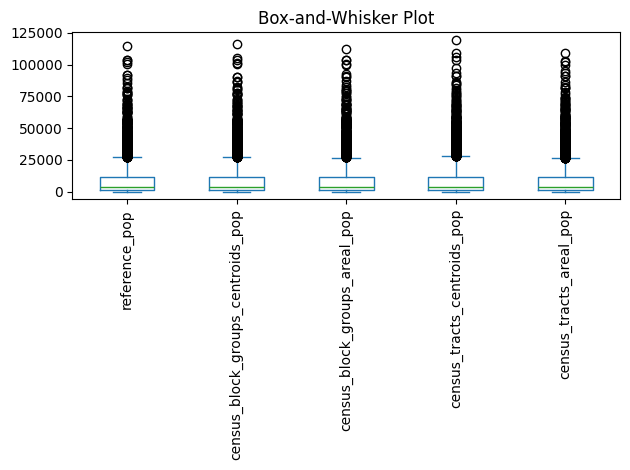

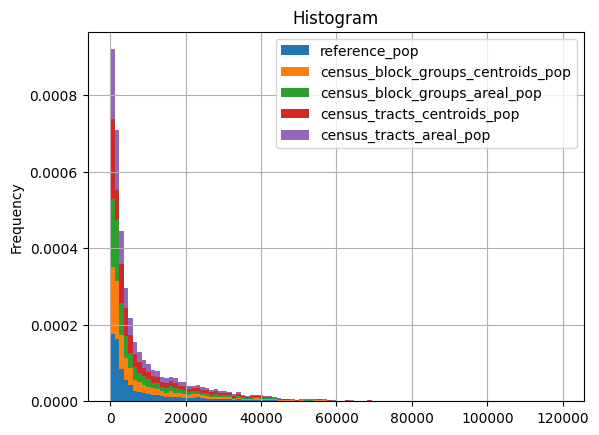

In [13]:
plot_population_distribution(zctas_gdf)

### 5C. Distribution of Absolute Errors

Relative to the official population count, the areal interpolation strategy using census block groups provided the lowest mean and median absolute error (approximately **443** and **275** persons, respectively), followed by centroids with census block groups (mean error: **628**, median error: **452**), areal interpolation with census tracts (mean error: **819**, median error: **493**), and centroids with census tracts (mean error: **1422**, median error: **1022**).  Interpolation with census tracts produced larger outliers compared to interpolation with block groups.

,census_block_groups_centroids_ref_pop_diff,census_block_groups_areal_ref_pop_diff,census_tracts_centroids_ref_pop_diff,census_tracts_areal_ref_pop_diff
count,5212.00000,5212.00000,5212.00000,5212.00000
mean,628.33020,443.78015,1421.51727,819.28820
std,644.13710,536.59685,1378.06008,1058.64240
min,0.00000,0.00000,0.00000,0.00000
25%,190.00000,108.48263,530.00000,207.02507
50%,452.00000,274.95787,1021.50000,492.88025
75%,849.00000,570.89989,1877.25000,1038.37112
max,7855.00000,5397.86659,19852.00000,21992.37273


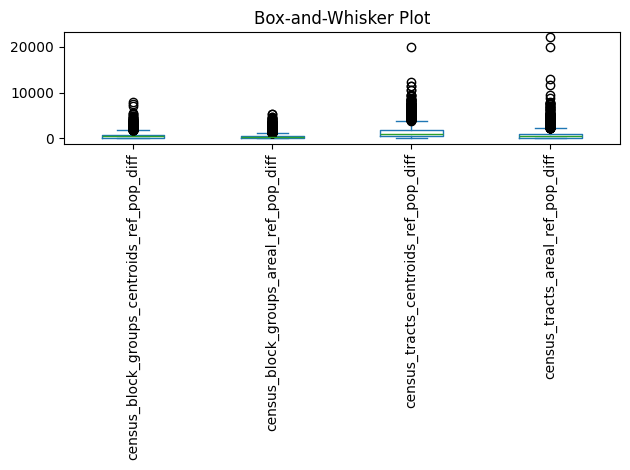

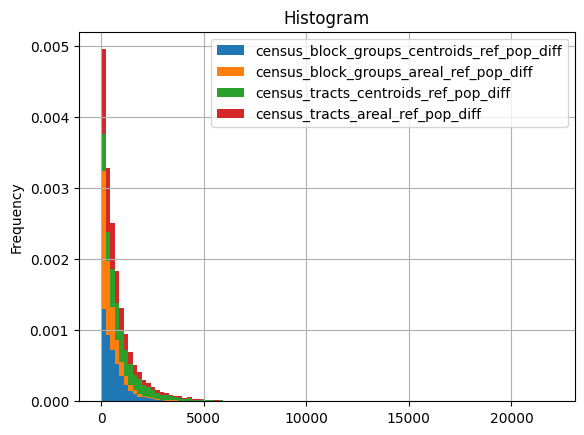

In [14]:
cols = [
    "census_block_groups_centroids_ref_pop_diff",
    "census_block_groups_areal_ref_pop_diff",
    "census_tracts_centroids_ref_pop_diff",
    "census_tracts_areal_ref_pop_diff",
]
abs_df = zctas_gdf[cols].apply(abs)
plot_population_error_distribution(abs_df)

### 5D. Mapping Large Discrepancies Between Strategies

Below we map the census block group boundaries, ZCTA boundaries, and population-weighted centroids corresponding to the biggest observed discrepancies between areal and point interpolation estimates. The discrepancy is measured as the absolute difference between the population estimates divided by the sum of the population estimates. Therefore, it is bound between 0 and 1, inclusive. When the estimates are equivalent, the discrepancy is zero, but the more the estimates diverge, the closer the discrepancy is to one. This approach was adopted to capture discrepancies for geographies of all sizes and not just those with the largest populations, which would occur if the discrepancy was measured using a simple difference between the estimates instead. NOTE: The maps should open in your default web browser.

#### 5D-1. Block Groups

In [15]:
map_block_group_discrepancies(
    zctas_gdf,
    blk_grp_centroids_gdf,
    blk_grps_gdf,
    target_geo_type="distresed communities"
)

#### 5D-2. Tracts

In [16]:
map_tract_discrepancies(
    zctas_gdf,
    tract_centroids_gdf,
    tracts_gdf,
    target_geo_type="distresed communities"
)

### 5E. Paired t-test

The difference between the areal and point interpolation strategies for census block groups was not found to be statistically signficiant at the 0.05 level, whereas the difference at the tract level was significant at ~0.00009. Similarly, there wasn't a statistically significant difference between block group point interpolation and tract point interpolation, but the difference between block group and tract areal interpolation had a p-value of ~8.88e-15. 

#### 5E-1. Census Block Groups: Point v. Areal Interpolation

In [17]:
run_paired_t_test(
    sample_a=zctas_gdf["census_block_groups_centroids_pop"],
    sample_b=zctas_gdf["census_block_groups_areal_pop"]
)

#### 5E-2. Census Tracts: Point v. Areal Interpolation

In [18]:
run_paired_t_test(
    sample_a=zctas_gdf["census_tracts_centroids_pop"],
    sample_b=zctas_gdf["census_tracts_areal_pop"]
)

#### 5E-3. Point Interpolation: Census Block Groups v. Census Tracts

In [19]:
run_paired_t_test(
    sample_a=zctas_gdf["census_block_groups_centroids_pop"],
    sample_b=zctas_gdf["census_tracts_centroids_pop"]
)

#### 5E-4. Areal Interpolation: Census Block Groups v. Census Tracts

In [20]:
run_paired_t_test(
    sample_a=zctas_gdf["census_block_groups_areal_pop"],
    sample_b=zctas_gdf["census_tracts_areal_pop"]
)

## 6. Case Study: Municipalities

In our second case study, we compare population estimation strategies for municipalities sourced from U.S. Census Bureau places and county subdivisions:

1. Point interpolation from population-weighted census block group centroids to municipal boundaries
2. Areal interpolation from census block group boundaries to municipal boundaries
3. Point interpolation from population-weighted census tract centroids to municipal boundaries
4. Areal interpolation from census tract boundaries to municipal boundaries

### 6A. Data Interpolation

We perform the four interpolations listed above, or load the datasets from the file system if they already exist.

In [21]:
# Configure target geography
target = TargetGeo(
    name="Municipalities",
    input_fpath=CLEAN_GEOPARQUET_DIR / MUNICIPALITIES_FNAME,
    output_fpath=CLEAN_ANALYSIS_DIR / MUNICIPALITIES_FNAME
)

# Load interpolations
munis_gdf = get_interpolations(target, origins, use_cached=True)
munis_gdf.head(2)

,name,geometry,reference_pop,census_block_groups_centroids_pop,census_block_groups_areal_pop,census_block_groups_centroids_ref_pop_diff,census_block_groups_areal_ref_pop_diff,census_block_groups_centroid_areal_pop_ratio,census_tracts_centroids_pop,census_tracts_areal_pop,census_tracts_centroids_ref_pop_diff,census_tracts_areal_ref_pop_diff,census_tracts_centroid_areal_pop_ratio
0,"AASTAD TOWNSHIP, OTTER TAIL COUNTY, MINNESOTA","MULTIPOLYGON (((-96.14200 46.19538, -96.14049 ...",191.00000,890.00000,224.53701,699.00000,33.53701,0.59708,0.00000,500.32379,-191.00000,309.32379,1.00000
1,"ABBEVILLE, ALABAMA","MULTIPOLYGON (((-85.29580 31.55385, -85.29575 ...",2358.00000,2532.00000,1185.39008,174.00000,-1172.60992,0.36225,2532.00000,1132.72931,174.00000,-1225.27069,0.38182


### 6B. Distribution of Population Counts

As with the ZCTAs, the distribution of the interpolated population counts roughly aligns with that of the official count published by the Census Bureau (`reference_pop`).  It should also be noted that the range of population for municipalities is much greater; the minimum is zero while the maximum is more than eight million.

,reference_pop,census_block_groups_centroids_pop,census_block_groups_areal_pop,census_tracts_centroids_pop,census_tracts_areal_pop
count,35729.00000,35729.00000,35729.00000,35729.00000,35729.00000
mean,7554.71499,7407.37703,7121.43624,7325.49008,6903.65590
std,64213.56006,64150.23065,64178.54625,64117.39830,63988.59654
min,0.00000,0.00000,0.01959,0.00000,0.02224
25%,295.00000,0.00000,95.35091,0.00000,67.61973
50%,1005.00000,1044.00000,754.44578,0.00000,619.88632
75%,3542.00000,3471.00000,3115.00000,4254.00000,2914.16710
max,8804190.00000,8804190.00000,8804190.00104,8804190.00000,8804190.00233


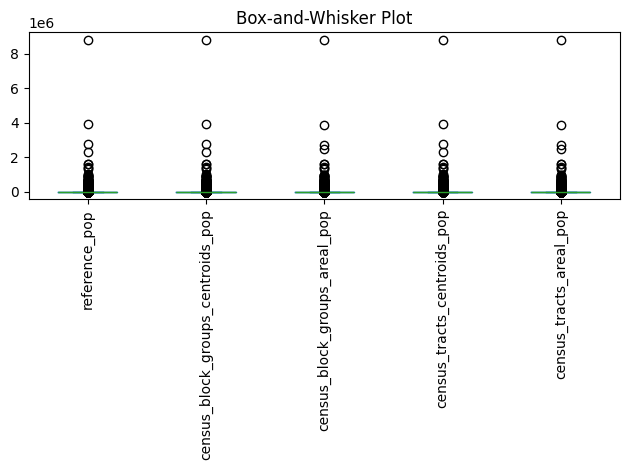

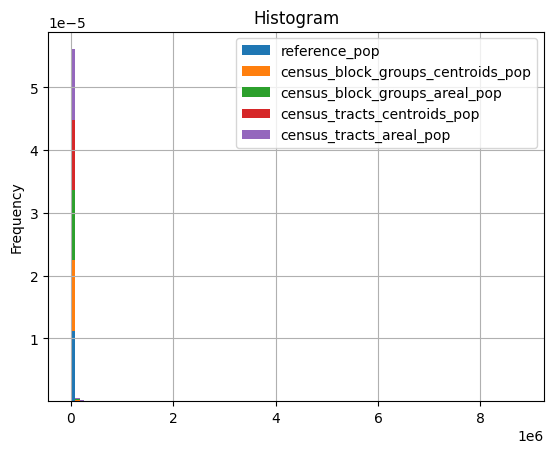

In [22]:
plot_population_distribution(munis_gdf)

### 6C. Distribution of Absolute Errors

On the whole, the areal and point interpolation strategies for census block groups performed similarly well in small municipalities relative to the official population count. As shown in the data table below, the areal estimate had a lower median absolute error (**~215** versus **~244** persons) but higher mean error (**~675** versus **~473** persons) due to huge outliers likely corresponding to large cities (see the max error, **185,054** persons). It is also worth mentioning that the point interpolation strategy probably performed better here compared to the distressed zip code tabulation areas because a significant portion of the municipalities are county subdivisions that perfectly align with census block groups and tracts. In those cases, the correct population-weighted centroids will _always_ fall within the municipalities' boundaries.
 
Finally, as with the distressed ZCTAs, census tract interpolation performed worse. The centroid strategy had mean and median errors of **~1,041** and **~515** persons, respectively, while the areal strategy had mean and median errors of **~1,051** and **~346** persons, respectively.

,census_block_groups_centroids_ref_pop_diff,census_block_groups_areal_ref_pop_diff,census_tracts_centroids_ref_pop_diff,census_tracts_areal_ref_pop_diff
count,35729.00000,35729.00000,35729.00000,35729.00000
mean,473.00546,674.85805,1041.63226,1051.65139
std,784.32025,1689.81023,1564.37022,2400.75435
min,0.00000,0.00000,0.00000,0.00000
25%,59.00000,43.59522,128.00000,93.49663
50%,244.00000,215.87673,515.00000,346.39461
75%,576.00000,716.11882,1370.00000,1042.15180
max,24368.00000,185054.29700,42537.00000,193148.62022


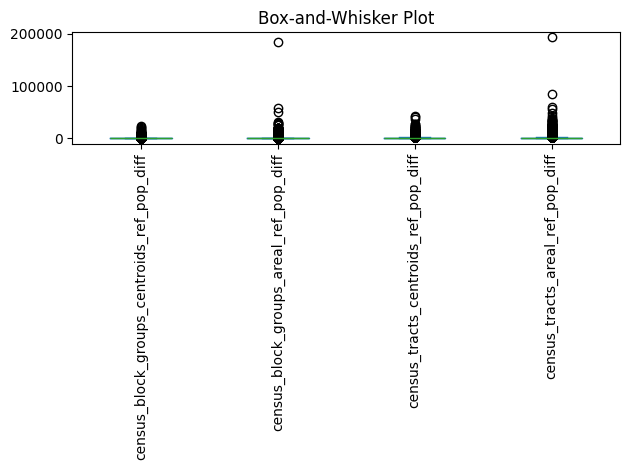

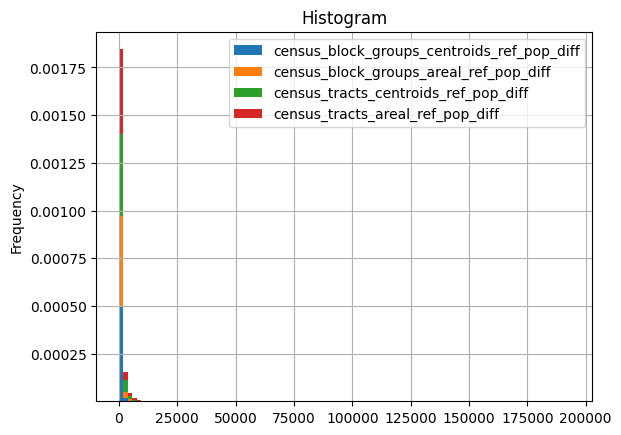

In [23]:
cols = [
    "census_block_groups_centroids_ref_pop_diff",
    "census_block_groups_areal_ref_pop_diff",
    "census_tracts_centroids_ref_pop_diff",
    "census_tracts_areal_ref_pop_diff",
]
abs_df = munis_gdf[cols].apply(abs)
plot_population_error_distribution(abs_df)

### 6D. Mapping Large Discrepancies Between Strategies

Below we map the census block group boundaries, municipality boundaries, and population-weighted centroids corresponding to the biggest observed discrepancies between areal and point interpolation estimates. Because there are tens of thousands of municipalities in the dataset, we restrict the map to the top 100 discrepancies to avoid crashing the notebook. NOTE: The maps should open in your default web browser.

In [24]:
muni_subset_blk_grps_gdf = munis_gdf.sort_values(
    by="census_block_groups_centroid_areal_pop_ratio", ascending=False
).head(100)
muni_subset_tracts_gdf = munis_gdf.sort_values(
    by="census_tracts_centroid_areal_pop_ratio", ascending=False
).head(100)

In [25]:
map_block_group_discrepancies(
    muni_subset_blk_grps_gdf,
    blk_grp_centroids_gdf,
    blk_grps_gdf,
    target_geo_type="municipalities - states"
)

In [26]:
map_tract_discrepancies(
    muni_subset_tracts_gdf,
    tract_centroids_gdf,
    tracts_gdf,
    target_geo_type="municipalities - states"
)

### 6E. Paired t-tests

The difference between the areal and point interpolation strategies for census block groups and tracts were both found to be statistically significant; however, this is less surprising given the large number of test samples (35,729).  As the number of samples increases, the sample mean converges to the true population value and smaller and smaller standard deviations from that value will qualify as significant. Likewise, the difference between block group and tract point interpolation and block group and tract areal interpolation were also statistically significant.

#### 6E-1. Census Block Groups: Point v. Areal Interpolation

In [27]:
run_paired_t_test(
    sample_a=munis_gdf["census_block_groups_centroids_pop"],
    sample_b=munis_gdf["census_block_groups_areal_pop"]
)

#### 6E-2. Census Tracts: Point v. Areal Interpolation

In [28]:
run_paired_t_test(
    sample_a=munis_gdf["census_tracts_centroids_pop"],
    sample_b=munis_gdf["census_tracts_areal_pop"]
)

#### 6E-3. Point Interpolation: Census Block Groups v. Census Tracts

In [29]:
run_paired_t_test(
    sample_a=munis_gdf["census_block_groups_centroids_pop"],
    sample_b=munis_gdf["census_tracts_centroids_pop"]
)

#### 6E-4. Areal Interpolation: Census Block Groups v. Census Tracts

In [30]:
run_paired_t_test(
    sample_a=munis_gdf["census_block_groups_areal_pop"],
    sample_b=munis_gdf["census_tracts_areal_pop"]
)

## 7. Discussion

Our results show that, all else equal, using smaller spatial units like census block groups as a data source instead of census tracts increases the accuracy of population estimates, especially when the target geography (e.g., municipalities, ZCTAs) itself is small. We also see that the point interpolation strategy handles densely-populated municipalities much better than areal interpolation, which had large outliers in its errors.

With that said, both areal and point interpolation fail in the face of non-uniform population distributions:

**Basic areal interpolation tends to underestimate populations in rural areas.** Census block groups are designed to hold between 600 and 3,000 residents. In rural areas with sparse populations, block groups typically span large land areas to satisfy this requirement. Consequently, these block groups also contain large swathes of land where the population is zero. This presents a problem for basic areal interpolation, which assumes that values are uniformly distributed across geographies rather than clustered. When we calculate the population of a small, rural municipality or ZCTA in a much larger block group by weighing the block group's population by the percent of land area shared with the municipality or ZCTA, the percent overlap is small and we underestimate the true value. The same principle applies when using census tracts.

For example, the municipality of King Cove, Alaska, falls within a much larger census block group, so the population estimated through areal interpolation is roughly 3 persons whereas the official population is 757 persons.

<img alt="Municpality of King Cove, Alaska, with overlapping census block groups and population-weighted centroids" src="./img/king_cove_alaska_municipality_discrepancy.png" width="800" />


**Basic areal interpolation can overestimate populations.** Conversely, when a municipality or ZCTA intersects with the majority of a census block but does not actually capture the main population center(s), the result is a population overestimation.  As an example, in greater San Antonio, Texas, ZCTA 78219 covers several census block groups. One of its block groups, highlighted below, has most of its area captured by the ZCTA but the population center represented by the red population-weighted centroid sits outside the ZCTA boundaries, likely causing an overcount for that block group. These errors add up. The areal interpolation etimate is about 4,000 persons greater than the official count.

<img alt="ZCTA 78219 in Greater San Antonio, Texas, with overlapping census block groups and population-weighted centroids" src="./img/greater_san_antonio_zcta_discrepancy.png" width="800" />


**The all-or-nothing approach of point interpolation results in simultaneous over- and underestimations of values for neighboring populations.** When there are several population clusters within a census block group, the population-weighted centroid is often located outside the boundaries of the intersecting municipality or ZCTA, which causes the municipality or ZCTA to have a population of zero. Alternatively, if the municipality or ZCTA has a large population, the centroid will be located inside, but it will "absorb" the populations of the surrounding areas and be inflated in value. For example, in the ZCTA highlighted below in greater Kansas City, Kansas, the population estimate from areal interpolation is 884—close to the official count of 831—whereas the estimation from point interpolation is zero because neither of its adjacent block groups' population-weighted centroids fall within its borders.

<img alt="ZCTA 64767 in Greater Kansas City, Kansas, with overlapping census block groups and population-weighted centroids" src="./img/greater_kansas_city_zcta_discrepancy.png" width="800" />

## 8. Conclusion

Using the official counts published by the U.S. Census Bureau as a source of "ground truth", we found that point interpolation using census block group level, population-weighted centroids produced the most accurate population estimates for geographies of different sizes. However, the strategy failed to account for population clusters that existed in close proximity, resulting in populations of zero as the centroids fell outside the geographies' boundaries.

To better handle the general problem of non-uniform spatial disribution of populations, a future analysis might compare this point interpolation approach with _dasymetric areal interpolation_, which masks out areas where persons are not expected to be living using additional datasets (e.g, building footprints, land cover rasters, city zoning boundaries). It could also investigate _inverse distance weighting_ to attribute populations based on proximity to the _N_ closest population-weighted centroid(s). For now, however, this centroid strategy seems acceptable for the tax credit bonus mapping widget given the relatively small size of the errors and the greater computational complexity of the alternative approaches.